In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 128 kB in 1s (213 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 128 not upgraded.
  Obtaining dependency information for numpy<2.3.0,>=2 from https://files.pythonhosted.org/packages/b4/63/3de6a34ad7ad6646ac7d2f55ebc6ad439dbbf9c4370017c50cf403fb19b5/numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: num

In [4]:
'''
import os
import shutil

base_dir = '/home/jovyan/CREMA-D-SPLIT'
splits = ['train', 'val', 'test']

for split in splits:
    split_dir = os.path.join(base_dir, split)
    for root, _, files in os.walk(split_dir):
        for file in files:
            if file.endswith('.mp4'):
                source = os.path.join(root, file)
                target = os.path.join(split_dir, file)
                
                # Move the file only if it's not already at the target location
                if source != target:
                    shutil.move(source, target)

    # After moving files, delete the now-empty emotion folders
    for subdir in os.listdir(split_dir):
        subdir_path = os.path.join(split_dir, subdir)
        if os.path.isdir(subdir_path):
            try:
                os.rmdir(subdir_path)  # Remove empty folders
            except OSError:
                # If folder is not empty (some error), print warning
                print(f"Warning: Could not remove {subdir_path}, it may not be empty.")
'''

In [3]:
import os
import shutil
from collections import Counter

# Emotion labels to track (based on filenames)
emotion_keywords = ["anger", "disgust", "fear", "happiness", "sadness"]

# Base path
base_dir = "/home/jovyan/CREMA-D-SPLIT"
folders = ["train", "val", "test"]

for folder in folders:
    current_path = os.path.join(base_dir, folder)
    print(f"Processing {current_path}")

    # Flatten the directory (move files to current_path root)
    for root, dirs, files in os.walk(current_path):
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(current_path, file)

            if src != dst:
                shutil.move(src, dst)

    # Remove empty subdirectories
    for root, dirs, files in os.walk(current_path, topdown=False):
        for d in dirs:
            dir_path = os.path.join(root, d)
            if not os.listdir(dir_path):
                os.rmdir(dir_path)

    # Count emotion classes in this folder
    files = os.listdir(current_path)
    emotion_counter = Counter()

    for file in files:
        for emotion in emotion_keywords:
            if emotion in file.lower():
                emotion_counter[emotion] += 1
                break  # Stop after first match

    # Display counts
    print(f"\nFile counts for {folder}:")
    total = 0
    for emotion in emotion_keywords:
        count = emotion_counter[emotion]
        print(f"{emotion}: {count}")
        total += count
    print(f"Total files: {total}\n")

print("All processing completed.")


Processing /home/jovyan/CREMA-D-SPLIT/train

File counts for train:
anger: 204
disgust: 204
fear: 206
happiness: 207
sadness: 204
Total files: 1025

Processing /home/jovyan/CREMA-D-SPLIT/val

File counts for val:
anger: 68
disgust: 68
fear: 68
happiness: 69
sadness: 68
Total files: 341

Processing /home/jovyan/CREMA-D-SPLIT/test

File counts for test:
anger: 70
disgust: 69
fear: 70
happiness: 69
sadness: 69
Total files: 347

All processing completed.


In [2]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2  # Added missing import

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:  # Changed variable name to avoid conflict
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  

input_size = 224
num_frame = 16
batch_size = 12 * strategy.num_replicas_in_sync  


train_uc_set = '/home/jovyan/CREMA-D-SPLIT/train'
val_uc_set = '/home/jovyan/CREMA-D-SPLIT/val'
test_uc_set = '/home/jovyan/CREMA-D-SPLIT/test'

uc_label2id = {'anger': 0, 'happiness': 1, 'disgust': 2, 'fear': 3, 'sadness': 4}
uc_id2label = {v: k for k, v in uc_label2id.items()}

import pandas as pd
def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion_full = video_file.split('_')[1]  # e.g., 'fear-HI'
            emotion = emotion_full.split('-')[0]     # extract 'fear'
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df


train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan//model"
pretrained_model = tf.saved_model.load(model_path)


class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Moved the model building code outside of the class definition
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    
    x = layers.Dense(512, activation='relu',  
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(len(uc_label2id),  
                        activation=None, 
                        dtype='float32')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="enhanced_model")
    
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,
            weight_decay=0.01  # Weight decay for additional regularization
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']  # Only tracking accuracy now
    )

model.summary()

history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=100,
)




2025-07-20 08:29:06.910550: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-07-20 08:29:08.690784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "enhanced_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                    

2025-07-20 08:29:22.743286: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1025
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
     

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-07-20 08:29:34.135375: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab8c073720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-20 08:29:34.135422: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-07-20 08:29:34.935423: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-20 08:29:40.242611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-07-20 08:29:52.154799: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6591_impl', 696 bytes spill stores, 696 bytes spill loads

2025-07-20 08:29:56.512418: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas w

85/85 [==============================] - ETA: 0s - loss: 2.6425 - accuracy: 0.3402

2025-07-20 08:31:41.979291: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 341
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

85/85 [==============================] - 177s 1s/step - loss: 2.6425 - accuracy: 0.3402 - val_loss: 2.4339 - val_accuracy: 0.2500
Epoch 2/100
85/85 [==============================] - 112s 1s/step - loss: 2.1354 - accuracy: 0.4490 - val_loss: 2.3031 - val_accuracy: 0.3482
Epoch 3/100
85/85 [==============================] - 109s 1s/step - loss: 2.0109 - accuracy: 0.4775 - val_loss: 2.6204 - val_accuracy: 0.3750
Epoch 4/100
85/85 [==============================] - 110s 1s/step - loss: 1.8456 - accuracy: 0.5343 - val_loss: 1.9053 - val_accuracy: 0.4613
Epoch 5/100
85/85 [==============================] - 112s 1s/step - loss: 1.7906 - accuracy: 0.5569 - val_loss: 2.0208 - val_accuracy: 0.4702
Epoch 6/100
85/85 [==============================] - 109s 1s/step - loss: 1.6758 - accuracy: 0.5755 - val_loss: 1.8073 - val_accuracy: 0.5000
Epoch 7/100
85/85 [==============================] - 107s 1s/step - loss: 1.6739 - accuracy: 0.5902 - val_loss: 1.8459 - val_accuracy: 0.5149
Epoch 8/100
85/85 

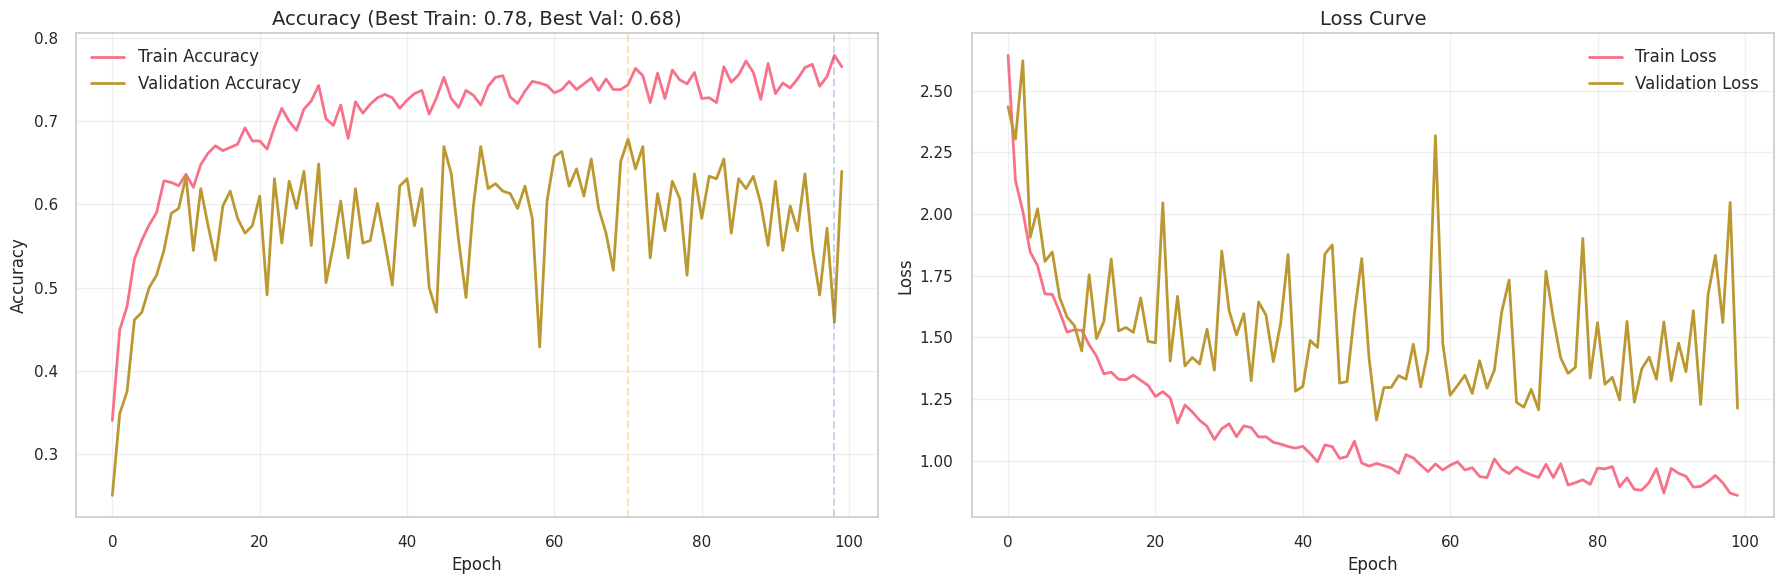


=== Key Performance Metrics ===
Highest Training Accuracy: 0.7794 at epoch 99
Highest Validation Accuracy: 0.6786 at epoch 71

Final Training Accuracy: 0.7657
Final Validation Accuracy: 0.6399

=== Test Set Evaluation ===


2025-07-20 17:37:25.614247: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 347
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

28/28 [==============================] - 28s 960ms/step - loss: 1.2190 - accuracy: 0.6488
Test Accuracy: 0.6488

=== Confusion Matrix (Validation Set) ===


2025-07-20 17:37:53.540328: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 341
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

28/28 [==============================] - 35s 797ms/step


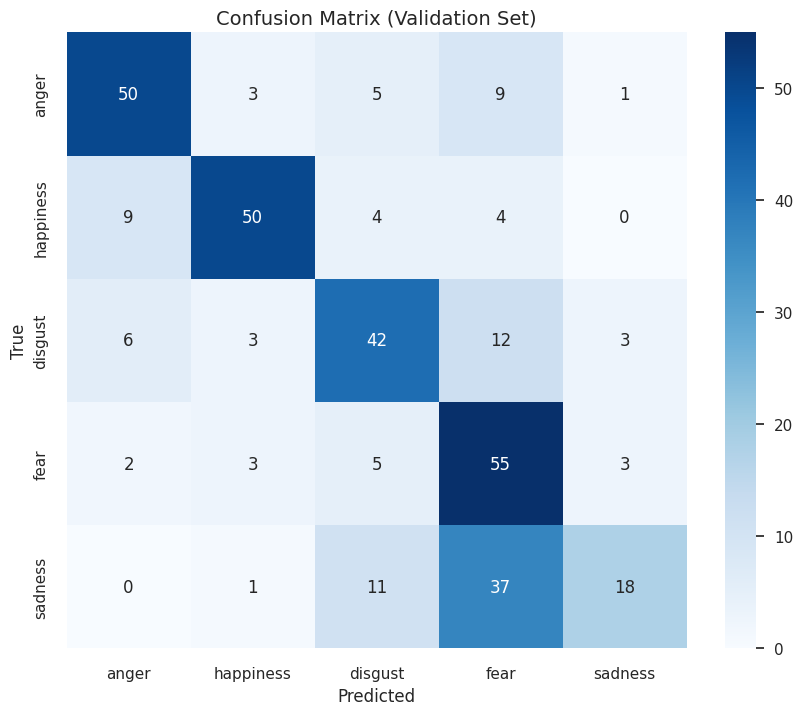


=== Classification Report (Validation Set) ===
              precision    recall  f1-score   support

       anger       0.75      0.74      0.74        68
   happiness       0.83      0.75      0.79        67
     disgust       0.63      0.64      0.63        66
        fear       0.47      0.81      0.59        68
     sadness       0.72      0.27      0.39        67

    accuracy                           0.64       336
   macro avg       0.68      0.64      0.63       336
weighted avg       0.68      0.64      0.63       336



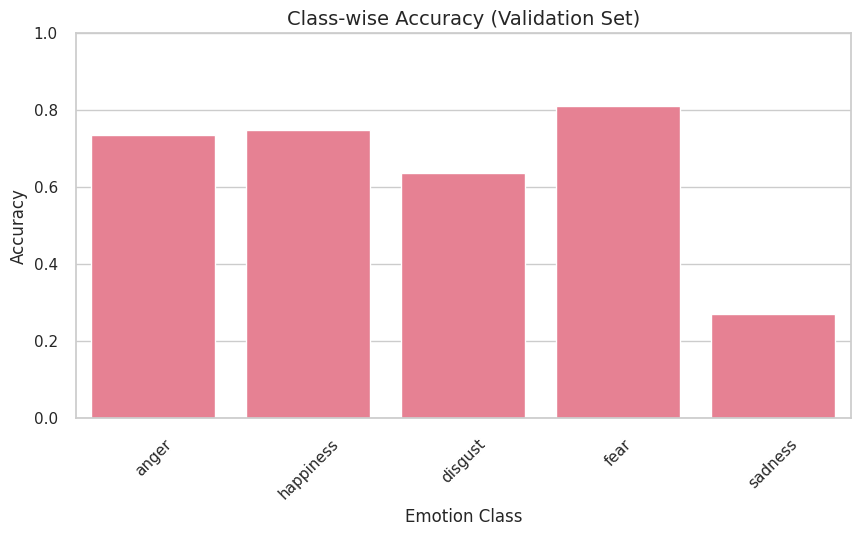

,Best Train Accuracy,Best Val Accuracy,Final Train Accuracy,Final Val Accuracy,Test Accuracy
0,0.779412,0.678571,0.765686,0.639881,0.648810


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Set style for better visualizations
plt.style.use('seaborn-v0_8')  # Updated style name
sns.set_theme(style="whitegrid")  # Updated seaborn theme
sns.set_palette("husl")

# 1. Plot training and validation accuracy/loss
plt.figure(figsize=(18, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)

# Mark best epochs
best_train_epoch = np.argmax(history.history['accuracy'])
best_val_epoch = np.argmax(history.history['val_accuracy'])

plt.axvline(x=best_train_epoch, color='b', linestyle='--', alpha=0.3)
plt.axvline(x=best_val_epoch, color='orange', linestyle='--', alpha=0.3)

plt.title(f'Accuracy (Best Train: {max(history.history["accuracy"]):.2f}, Best Val: {max(history.history["val_accuracy"]):.2f})', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss Curve', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Print key metrics
print("\n=== Key Performance Metrics ===")
print(f"Highest Training Accuracy: {max(history.history['accuracy']):.4f} at epoch {best_train_epoch + 1}")
print(f"Highest Validation Accuracy: {max(history.history['val_accuracy']):.4f} at epoch {best_val_epoch + 1}")

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# 3. Evaluate on test set
print("\n=== Test Set Evaluation ===")
test_loss, test_acc = model.evaluate(test_uc_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# 4. Confusion Matrix (on validation set)
print("\n=== Confusion Matrix (Validation Set) ===")
val_preds = model.predict(val_uc_ds)
val_pred_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = np.concatenate([y for x, y in val_uc_ds], axis=0)

cm = confusion_matrix(val_true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=uc_label2id.keys(), 
            yticklabels=uc_label2id.keys())
plt.title('Confusion Matrix (Validation Set)', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

# 5. Classification Report
print("\n=== Classification Report (Validation Set) ===")
print(classification_report(val_true_classes, val_pred_classes, 
                           target_names=uc_label2id.keys()))

# 6. Class-wise Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(uc_label2id.keys()), y=class_accuracy)
plt.title('Class-wise Accuracy (Validation Set)', fontsize=14)
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# 7. Training Summary Table
summary_data = {
    'Best Train Accuracy': [max(history.history['accuracy'])],
    'Best Val Accuracy': [max(history.history['val_accuracy'])],
    'Final Train Accuracy': [history.history['accuracy'][-1]],
    'Final Val Accuracy': [history.history['val_accuracy'][-1]],
    'Test Accuracy': [test_acc]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df.style.background_gradient(cmap='Blues').set_caption("Model Performance Summary"))